In [1]:
import numpy as np
import pandas as pd
import pathlib as pl
from dataclasses import dataclass, field

def train_test_split_indices(papers, test_size=0.2, rng=None) -> tuple[np.ndarray[int], np.ndarray[int]]:
    """
    Splits a list of papers into train and test indices.

    Parameters
    ----------
    papers : iterable of papers with ids
        List or dict of papers to split.
    test_size : float, optional
        if < 1, proportion of papers to reserve for testing, by default 0.2
        if > 1, number of papers to reserve for testing
    rng : int, optional
        Random state for the random number generator, default uses numpy's random

    Returns
    -------
    train_indices : list of int
        List of indices for the training set.
    test_indices : list of int
        List of indices for the testing set.
    """
    n = papers if isinstance(papers, int) else len(papers)
    if test_size < 1:
        test_size = int(np.floor(test_size * n))  # number of papers in test
    if rng is None:
        rng = np.random.default_rng()  # setup rng
    elif isinstance(rng, int):
        rng = np.random.default_rng(rng)

    if isinstance(papers, int):
        indices = np.arange(n)  # generate indices
    elif isinstance(papers, dict):
        indices = [paper.idx for paper in papers.values()]  # grab indices from dict entries
    else:  # assume papers is a dict or mapping of papers with a .values() method
        indices = papers  # assume papers is a list of indices
    indices = np.asarray(indices)

    # shuffle and split
    rng.shuffle(indices)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    return train_indices, test_indices

In [2]:
@dataclass
class Paper:
    idx: str  # Paper ID
    label: str  # Paper category/topic
    features: tuple[bool, ...] = ()  # binary features
    citations: list[str] = field(default_factory=list)  # IDs of papers cited by this paper


papers = {}
missing = set()

# Load in training data
content = pd.read_csv("data/citeseer/citeseer.content", sep="\t", header=None, dtype=object)
citations = pd.read_csv("data/citeseer/citeseer.cites", sep="\t", header=None, dtype=object)

labels = set()  # set of unique labels

for paper in content.itertuples(index=False):  # create papers from data
    # if paper[-1] == 'IR':
    #     continue
    idx = paper[0]
    features = tuple([int(feature) for feature in paper[1:-1]])  # parse features
    papers[idx] = Paper(idx, paper[-1], features)  # create paper object
    labels.add(paper[-1])  # label is the last column. add to set of labels

for paper_idx, citation in citations.itertuples(index=False):
    try:  # parse citations
        if citation not in papers:
            missing.add(citation)  # if citation is missing, add to missing list
            continue
        papers[paper_idx].citations.append(citation)
    except KeyError:
        missing.add(paper_idx)  # if paper is missing, add to missing list

print(f"Loaded {len(papers)} papers and skipped {len(missing)} broken references.")

labels  # show labels set

Loaded 3312 papers and skipped 15 broken references.


{'AI', 'Agents', 'DB', 'HCI', 'IR', 'ML'}

In [3]:
def components_undirected(papers):

    components = []

    for idx, paper in papers.items():
        new_component = {idx}  # new set
        new_component.update(paper.citations)  # add its citations
        matching_sets = [c for c in components if c & new_component]  # find existing components with overlap
        new_component = new_component.union(*matching_sets)  # merge overlapping components
        for s in matching_sets:  # remove any old overlapping components
            components.remove(s)
        components.append(new_component)  # add our new component

    return components

In [4]:
components = sorted(components_undirected(papers), key=len, reverse=True)
largest = components[0]

print([len(c) for c in components])
print(f"Found {len(components)} components, the largest has {len(largest)} papers")

[2110, 18, 17, 15, 13, 12, 12, 11, 10, 10, 9, 9, 9, 9, 9, 8, 8, 8, 8, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [5]:
def writeout(papers, path_stem, train_idxs=None, test_idxs=None, metadata=''):
    path = pl.Path(path_stem)
    if path.is_dir():
        raise ValueError(f"{path} is a directory")
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path.with_suffix('.content'), 'w') as f:
        for paper in papers.values():
            features = [str(int(feature)) for feature in paper.features]
            features = '\t'.join(features)
            f.write(f"{paper.idx:s}\t{features}\t{paper.label:s}\n")
    with open(path.with_suffix('.cites'), 'w') as f:
        for paper in papers.values():
            for cite in paper.citations:
                f.write(f"{paper.idx:s}\t{cite:s}\n")
    if train_idxs is not None and test_idxs is not None:
        train_idxs = [str(idx) for idx in train_idxs]
        test_idxs = [str(idx) for idx in test_idxs]
        with open(path.with_suffix('.indices'), 'w') as f:
            f.write(f"training_indices {len(train_idxs)} \\n test_indices {len(test_idxs)}\t{metadata}\n")
            f.write(', '.join(train_idxs))
            f.write('\n' + ', '.join(test_idxs))


In [6]:
def remove_broken_citations(papers):
    removed = set()
    for paper in papers.values():
        for citation in paper.citations:
            if citation not in papers:
                removed.add(citation)
                paper.citations.remove(citation)
    return removed


def rebuild(papers, ids):
    new_papers = {k: v for k, v in papers.items() if k in ids}
    removed_citations = remove_broken_citations(new_papers)
    return new_papers, removed_citations

In [7]:
seed = 2025

train_idxs, test_idxs = train_test_split_indices(papers, test_size=0.8, rng=seed)

miniseer, removed = rebuild(papers, largest)
assert not removed
m_train_idxs, m_test_idxs = train_test_split_indices(miniseer, test_size=0.8, rng=seed)
writeout(miniseer, 'data/miniseer/miniseer', m_train_idxs, m_test_idxs, f"seed: {seed}")

_train_idxs, microseer_idxs = train_test_split_indices(miniseer, test_size=87, rng=seed)
u_train_idxs, u_test_idxs = train_test_split_indices(microseer_idxs, test_size=0.8, rng=seed)
microseer, removed = rebuild(papers, microseer_idxs)
writeout(microseer, 'data/microseer/microseer', u_train_idxs, u_test_idxs, f"seed: {seed}")

In [8]:
def how_many(papers, train_idxs=None):
    n_papers = len(papers)
    n_citations = sum([len(paper.citations) for paper in papers.values()])
    n_topics = len(labels)
    print(f"Papers: {n_papers}, Citations: {n_citations}, Topics: {n_topics}")
    if train_idxs is None:
        print(f"NEST-like implementation will use {n_papers + n_topics} neurons")
    else:
        n_train, n_test = len(train_idxs), n_papers - len(train_idxs)
        print(f"NEST-like implementation will use {n_papers + n_topics} neurons, {n_citations * 2 + n_test * n_topics * 2 + n_train * 2} synapses")  # TODO: Check this
        # print(f"K implementation will use {n_papers + n_topics} neurons, {n_citations + n_papers} synapses")
        print(f"Train: {n_train}, Test: {n_test} ({n_train / n_papers:.2f}:{n_test / n_papers:.2f})")

print("Original dataset:")
how_many(papers, train_idxs)
print("\nMiniseer:")
how_many(miniseer, m_train_idxs)
print("\nMicroseer:")
how_many(microseer, u_train_idxs)

Original dataset:
Papers: 3312, Citations: 4643, Topics: 6
NEST-like implementation will use 3318 neurons, 42400 synapses
Train: 663, Test: 2649 (0.20:0.80)

Miniseer:
Papers: 2110, Citations: 3685, Topics: 6
NEST-like implementation will use 2116 neurons, 28470 synapses
Train: 422, Test: 1688 (0.20:0.80)

Microseer:
Papers: 87, Citations: 42, Topics: 6
NEST-like implementation will use 93 neurons, 948 synapses
Train: 18, Test: 69 (0.21:0.79)


In [9]:
def topics_counts(papers):
    topics_count = {}
    for paper in papers.values():
        topics_count[paper.label] = topics_count.get(paper.label, 0) + 1
    return topics_count

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

categories = pd.DataFrame({
    'original': pd.Series(topics_counts(papers)),
    'miniseer': pd.Series(topics_counts(miniseer)),
    'microseer': pd.Series(topics_counts(microseer)),
}).T

categories

,AI,Agents,DB,HCI,IR,ML
original,249,596,701,508,668,590
miniseer,115,463,388,304,532,308
microseer,2,21,13,14,24,13


<Axes: xlabel='topic', ylabel='count'>

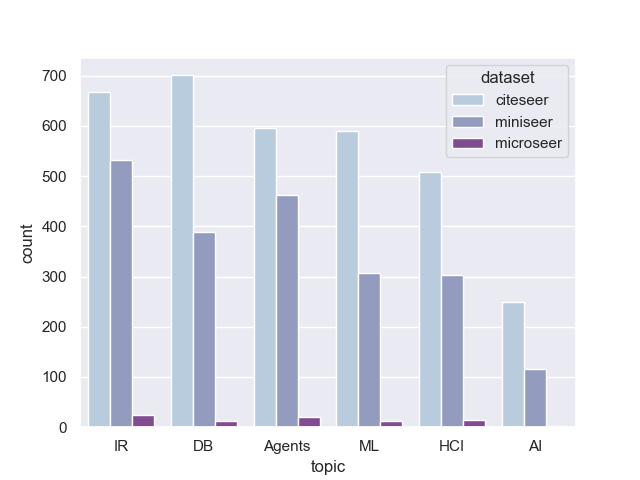

In [11]:
def todf(papers, name):
    df = pd.DataFrame([{'name': paper.idx, 'topic': paper.label, 'citations': len(paper.citations)} for paper in papers.values()])
    df['dataset'] = name
    return df


data = pd.concat([
    todf(papers, 'citeseer'),
    todf(miniseer, 'miniseer'),
    todf(microseer, 'microseer')])
sns.set_theme(style="darkgrid", palette=sns.color_palette(['#b3cde3', '#8c96c6', '#88419d']))
%matplotlib widget
fig, ax = plt.subplots()
index = data['topic'].value_counts().index
sns.countplot(data, x='topic', hue='dataset', order=index)

(0.0, 30.0)

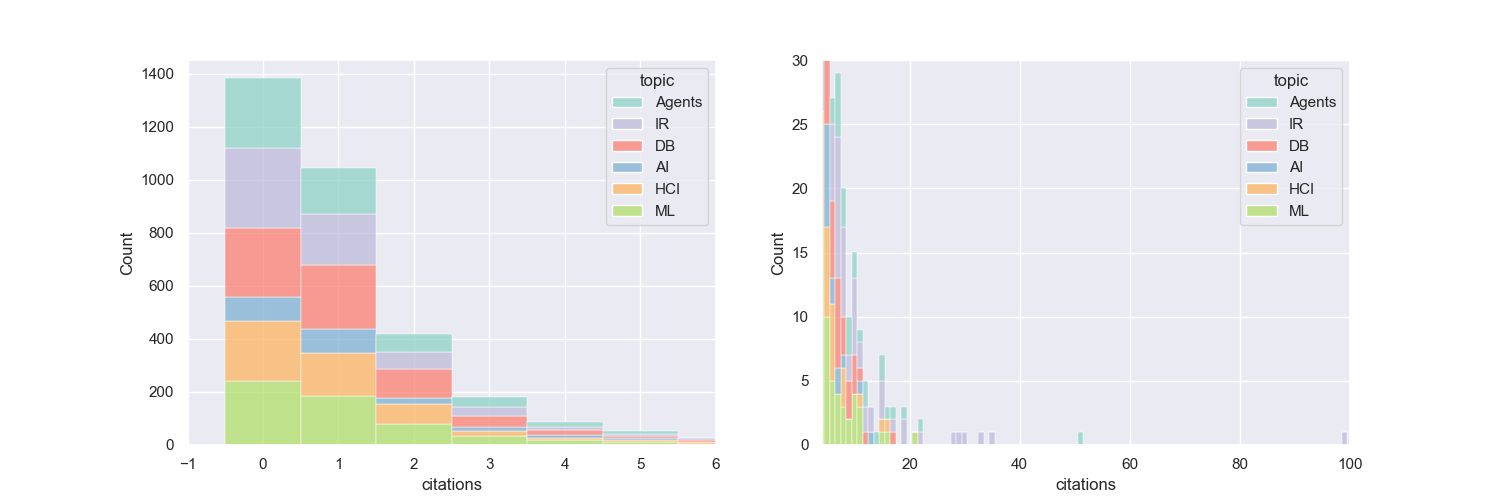

In [12]:
citeseer_df = todf(papers, 'citeseer')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_theme(style="darkgrid", palette=sns.color_palette(['#8dd3c7', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69']))
sns.histplot(
    citeseer_df, x='citations', hue='topic', ax=ax1,
    discrete=True,
    multiple='stack',
    # multiple='dodge',
    # log_scale=True,
)
# ax.set_xscale('log')
ax1.set_xlim(-1, 6)
sns.histplot(
    citeseer_df, x='citations', hue='topic', ax=ax2,
    discrete=True,
    multiple='stack',
    # multiple='dodge',
    # log_scale=True,
)
ax2.set_xlim(4, 100)
ax2.set_ylim(0, 30)